In [213]:

from pathlib import Path
from osgeo import gdal
import rasterio.plot
import geopandas as gpd
from requests import Request
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio import MemoryFile
from urllib.request import urlopen

## 0. Creation de la mosaique

In [96]:
path = Path('data/input/ORTHOHR_1-0_IRC-0M20_JP2-E080_LAMB93_D091_2021-01-01/ORTHOHR/1_DONNEES_LIVRAISON_2022-06-00154/OHR_IRC_0M20_JP2-E080_LAMB93_D91-2021')
vrt_path = 'data/intermediate/orthophoto91-mosaic.vrt'

In [97]:
filepaths = [str(x) for x in path.rglob('*.jp2')]  # list of paths to raster files
  # path to vrt to build
ds = gdal.BuildVRT(vrt_path, filepaths)
ds.FlushCache()

## 1. Collection des données BD Topo

In [182]:
code_insee = '91339'
base_url = 'https://wxs.ign.fr/topographie/geoportail/wfs?'
params = {
    'version' : '2.0.0',
    'request' : 'GetFeature',
    'typeName' : 'BDTOPO_V3:commune',
    'filter' : f'<Filter><PropertyIsEqualTo><PropertyName>code_insee</PropertyName><Literal>{code_insee}</Literal></PropertyIsEqualTo></Filter>',
    'outputFormat' : 'json'
}


# Parse the URL with parameters
wfs_request_url = Request('GET', base_url, params=params).prepare().url
commune = gpd.read_file(wfs_request_url)


## 2. Decouper BD Ortho 
### 2.1 Depuis le flux WMS

In [226]:
minx, miny, maxx, maxy = commune.total_bounds
bbox_str = ','.join([str(miny), str(minx), str(maxy), str(maxx)])

In [235]:
base_url = 'https://wxs.ign.fr/ortho/geoportail/r/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetCapabilities'
params = {
    'service' : 'WMS',
    'version' : '1.3.0',
    'request' : 'GetMap',
    'layers' : 'ORTHOIMAGERY.ORTHOPHOTOS.IRC',
    'width' : 2048,
    'height' : 2048,
    'bbox' : bbox_str,
    'styles' : '',
    'format' : 'image/geotiff',
    'crs' : f'EPSG:{commune.crs.to_epsg()}'
}

wms_request_url = Request('GET', base_url, params=params).prepare().url
print(wms_request_url)
tif_bytes = urlopen(wms_request_url).read()

with MemoryFile(tif_bytes) as memfile:
     with memfile.open() as ortho:
        cropped, crop_trans = mask(ortho, [commune.iloc[0].geometry], crop=True)


https://wxs.ign.fr/ortho/geoportail/r/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetCapabilities&service=WMS&version=1.3.0&request=GetMap&layers=ORTHOIMAGERY.ORTHOPHOTOS.IRC&width=2048&height=2048&bbox=48.61292939%2C2.22327836%2C48.63932019%2C2.2817485&styles=&format=image%2Fgeotiff&crs=EPSG%3A4326


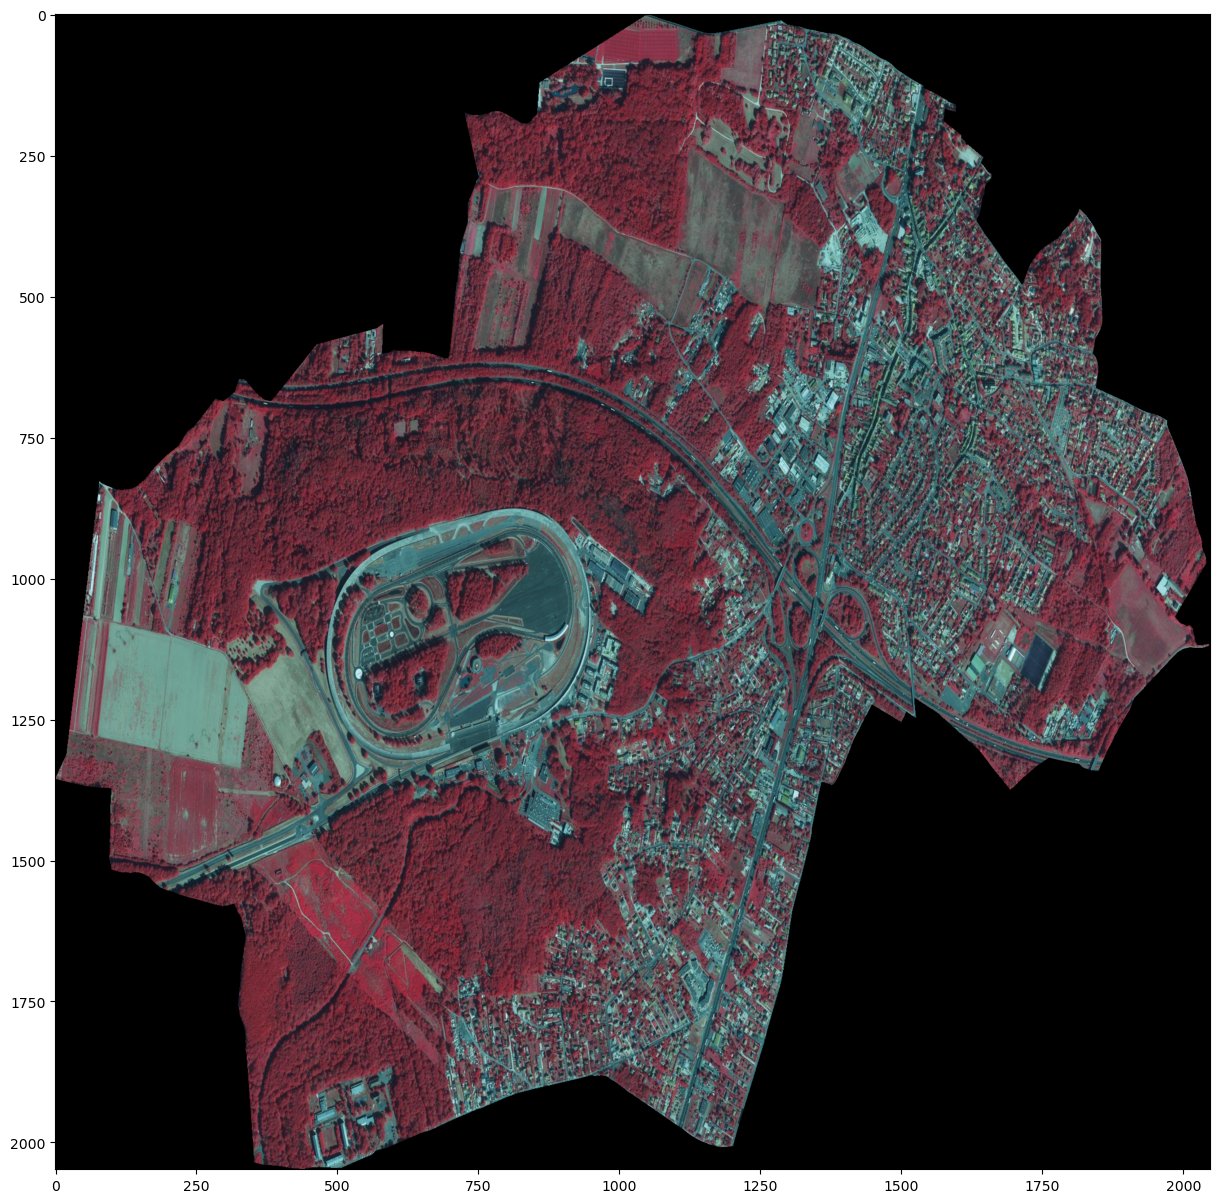

<AxesSubplot:>

In [236]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(cropped)

### 2.2 Depuis la mosaique

In [230]:
mosaic_path = 'data/input/ORTHOHR_1-0_IRC-0M20_JP2-E080_LAMB93_D091_2021-01-01/ORTHOHR/3_SUPPLEMENTS_LIVRAISON_2022-06-00154/OHR_IRC_0M20_JP2-E080_LAMB93_D91-2021/mosaique_POSIX.vrt'
communeL93 = commune.to_crs(epsg=2154)
with rasterio.open(mosaic_path) as raster_vrt:
    cropped, crop_trans = mask(raster_vrt, [communeL93.iloc[0].geometry], crop=True)

<AxesSubplot:>

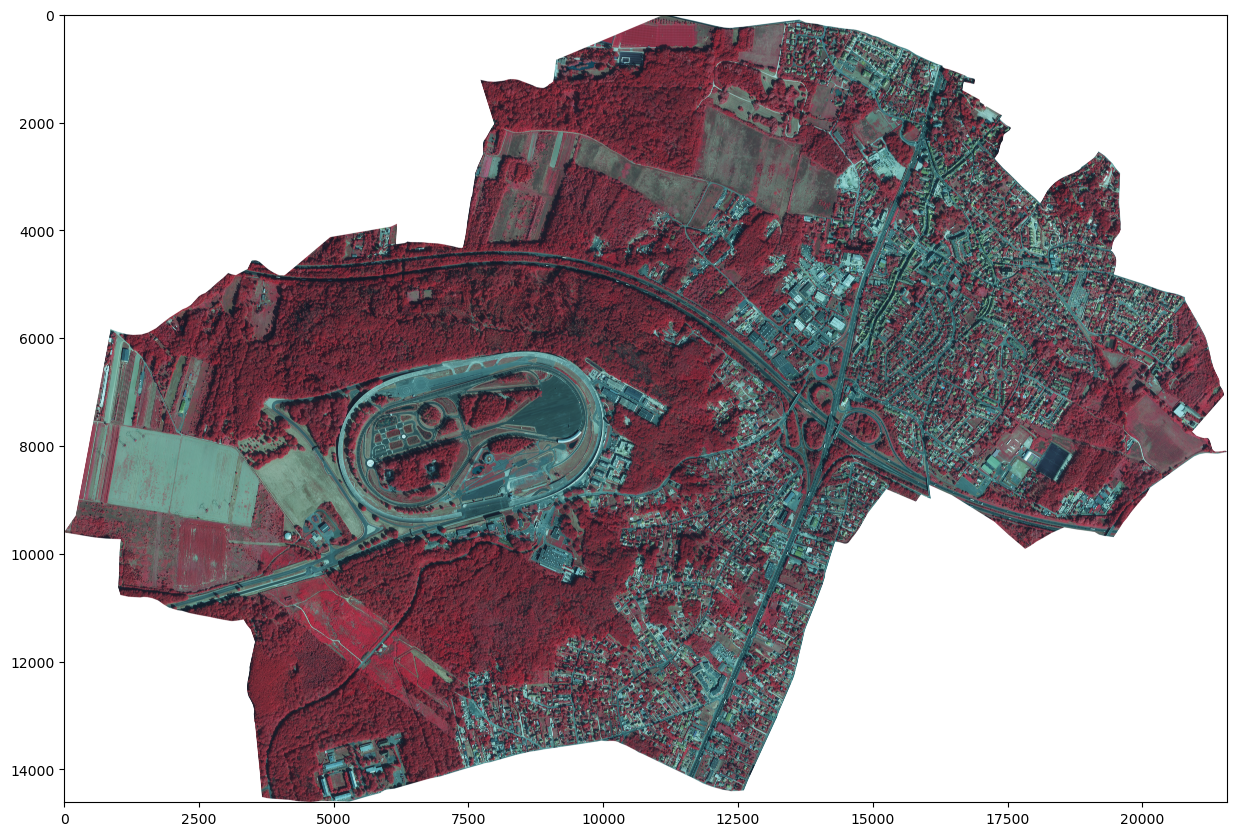

In [231]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(cropped, ax=ax)